**Main Train Script** 

In [1]:
# main_train.ipynb

# Import necessary libraries
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Import the models
from alexnet_with_lrn import AlexNetWithLRN
from googlenet_modified import GoogLeNet
from inception_net import Inception



Using device: cuda:0


In [3]:
# Ensure reproducibility
#torch.manual_seed(42)
# Preprocessing for CIFAR-10
preprocess = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(112),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# CIFAR-10 Dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [40000, 10000])
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}




Files already downloaded and verified
Files already downloaded and verified


In [4]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10, weights_name='model_weights', is_inception=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            epoch_start = time.time()

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux1, aux2 = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux1, labels)
                        loss3 = criterion(aux2, labels)
                        loss = loss1 + 0.3 * loss2 + 0.3 * loss3
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_time = time.time() - epoch_start

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            print(f"Epoch time taken: {epoch_time:.4f} seconds")

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f"{weights_name}_best.pth")

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [5]:
def plot_training_results(train_loss, train_acc, val_loss, val_acc):
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Epoch 0/9
----------
train Loss: 2.2721 Acc: 0.1218
Epoch time taken: 37.5512 seconds
val Loss: 2.0281 Acc: 0.2124
Epoch time taken: 4.4614 seconds

Epoch 1/9
----------
train Loss: 1.8237 Acc: 0.2808
Epoch time taken: 32.7450 seconds
val Loss: 1.6602 Acc: 0.3588
Epoch time taken: 4.4785 seconds

Epoch 2/9
----------
train Loss: 1.4578 Acc: 0.4528
Epoch time taken: 38.0985 seconds
val Loss: 1.3794 Acc: 0.5057
Epoch time taken: 4.5684 seconds

Epoch 3/9
----------
train Loss: 1.2067 Acc: 0.5598
Epoch time taken: 35.9112 seconds
val Loss: 1.1692 Acc: 0.5803
Epoch time taken: 4.5349 seconds

Epoch 4/9
----------
train Loss: 1.0228 Acc: 0.6337
Epoch time taken: 40.1453 seconds
val Loss: 0.9718 Acc: 0.6542
Epoch time taken: 4.5087 seconds

Epoch 5/9
----------
train Loss: 0.8811 Acc: 0.6898
Epoch time taken: 44.3244 seconds
val Loss: 0.8854 Acc: 0.6926
Epoch time taken: 4.9965 seconds

Epoch 6/9
----------
train Loss: 0.7596 Acc: 0.7334
Epoch time taken: 35.4824 seconds
val Loss: 0.8428 Acc

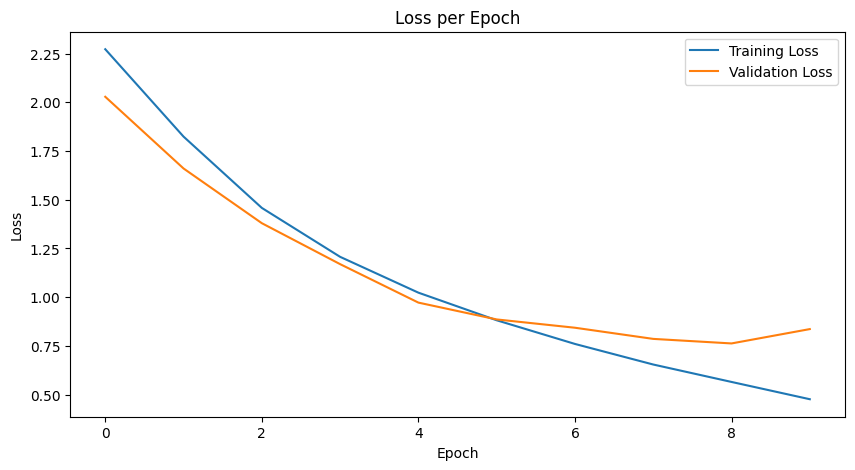

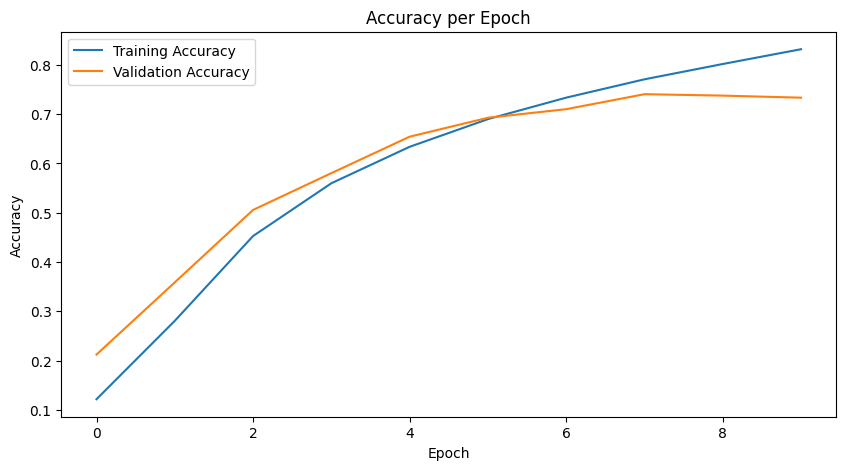

In [6]:
alexnet = AlexNetWithLRN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

trained_alexnet, train_loss_alex, train_acc_alex, val_loss_alex, val_acc_alex = train_model(
    alexnet, dataloaders, criterion, optimizer, num_epochs=10, weights_name='alexnet_lrn'
)

plot_training_results(train_loss_alex, train_acc_alex, val_loss_alex, val_acc_alex)

In [7]:
# Preprocess inputs to 3x32x32 with CIFAR-specific normalization parameters

preprocess = transforms.Compose([
    transforms.Resize(36),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Download CIFAR-10 and set up train, validation, and test datasets with new preprocess object

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=preprocess)

train_datset, val_dataset = torch.utils.data.random_split(train_dataset, [40000, 10000])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=preprocess)

# Create DataLoaders

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                               shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128,
                                             shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128,
                                              shuffle=False, num_workers=2)

dataloaders = { 'train': train_dataloader, 'val': val_dataloader }

Files already downloaded and verified
Files already downloaded and verified


In [9]:
def train_model_g(model, dataloaders, criterion, optimizer, num_epochs=25, weights_name='model_weights', is_inception=False):
    """
    Train a PyTorch model with optional support for auxiliary outputs (for GoogLeNet).
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux1, aux2 = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux1, labels)
                        loss3 = criterion(aux2, labels)
                        loss = loss1 + 0.3 * loss2 + 0.3 * loss3
                    else:
                        outputs = model(inputs)
                        if isinstance(outputs, tuple):  # Handle tuple outputs for GoogLeNet
                            outputs = outputs[0]  # Extract main output
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f"{weights_name}_best.pth")

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history


In [10]:
# Train GoogLeNet
googlenet = GoogLeNet().to(device)
criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.Adam(googlenet.parameters(), lr=0.01)

best_model3, train_acc_history3, val_acc_history3, train_loss_history3, val_loss_history3 = train_model_g(
    googlenet, dataloaders, criterion_3, optimizer_3, num_epochs=10, weights_name='googlenet_lr_0.01_bestsofar', is_inception=True
)

Epoch 0/9
----------
train Loss: 5.0032 Acc: 0.2032
val Loss: 1.7963 Acc: 0.2816

Epoch 1/9
----------
train Loss: 2.7732 Acc: 0.3462
val Loss: 1.7330 Acc: 0.3670

Epoch 2/9
----------
train Loss: 2.2845 Acc: 0.4817
val Loss: 1.2927 Acc: 0.5339

Epoch 3/9
----------
train Loss: 1.9471 Acc: 0.5772
val Loss: 1.2069 Acc: 0.5673

Epoch 4/9
----------
train Loss: 1.7058 Acc: 0.6308
val Loss: 0.9869 Acc: 0.6490

Epoch 5/9
----------
train Loss: 1.4836 Acc: 0.6822
val Loss: 0.8679 Acc: 0.6956

Epoch 6/9
----------
train Loss: 1.3377 Acc: 0.7159
val Loss: 0.7041 Acc: 0.7542

Epoch 7/9
----------
train Loss: 1.2318 Acc: 0.7393
val Loss: 0.7251 Acc: 0.7480

Epoch 8/9
----------
train Loss: 1.1165 Acc: 0.7655
val Loss: 0.6214 Acc: 0.7803

Epoch 9/9
----------
train Loss: 1.0300 Acc: 0.7841
val Loss: 0.6675 Acc: 0.7647

Training complete in 4m 23s
Best val Acc: 0.7803


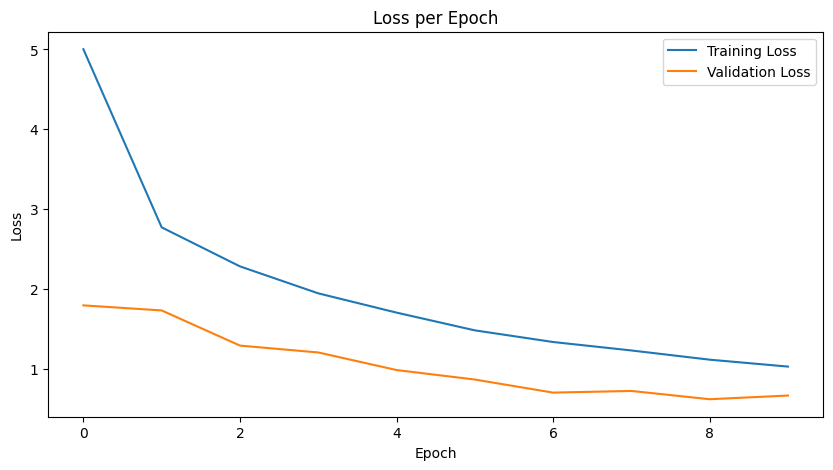

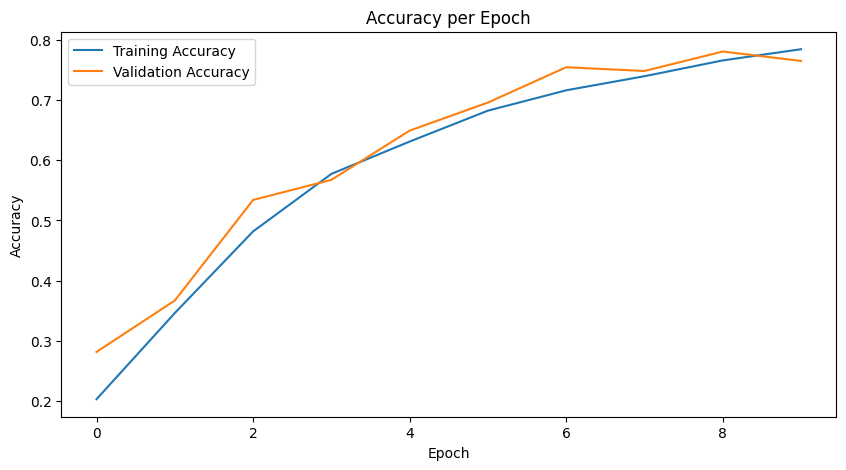

In [11]:
plot_training_results(train_loss_history3, train_acc_history3, val_loss_history3, val_acc_history3)

In [13]:
# Preprocessing for CIFAR-10
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# CIFAR-10 Dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=preprocess)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [40000, 10000])
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=preprocess)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}


Files already downloaded and verified
Files already downloaded and verified


In [14]:
# Pretrained AlexNet
pretrained_alexnet = models.alexnet(pretrained=True)
pretrained_alexnet.classifier[6] = nn.Linear(4096, 10)  # Change output layer for CIFAR-10
pretrained_alexnet = pretrained_alexnet.to(device)

optimizer = optim.SGD(pretrained_alexnet.parameters(), lr=0.001, momentum=0.9)
trained_pretrained_alexnet, _, _, _, _ = train_model(pretrained_alexnet, dataloaders, criterion, optimizer, num_epochs=10)

# Pretrained GoogLeNet
pretrained_googlenet = models.googlenet(pretrained=True, aux_logits=True)
pretrained_googlenet.fc = nn.Linear(1024, 10)  # Change output layer for CIFAR-10
pretrained_googlenet.aux1.fc2 = nn.Linear(1024, 10)  # Change auxiliary classifiers
pretrained_googlenet.aux2.fc2 = nn.Linear(1024, 10)
pretrained_googlenet = pretrained_googlenet.to(device)

optimizer = optim.Adam(pretrained_googlenet.parameters(), lr=0.001)
trained_pretrained_googlenet, _, _, _, _ = train_model(pretrained_googlenet, dataloaders, criterion, optimizer, num_epochs=10, is_inception=True)

/home/jupyter-st124872/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jupyter-st124872/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9
----------
train Loss: 0.6685 Acc: 0.7664
Epoch time taken: 39.2016 seconds
val Loss: 0.4237 Acc: 0.8513
Epoch time taken: 10.7822 seconds

Epoch 1/9
----------
train Loss: 0.4251 Acc: 0.8528
Epoch time taken: 40.3271 seconds
val Loss: 0.3828 Acc: 0.8671
Epoch time taken: 9.9287 seconds

Epoch 2/9
----------
train Loss: 0.3281 Acc: 0.8841
Epoch time taken: 41.7962 seconds
val Loss: 0.3836 Acc: 0.8651
Epoch time taken: 10.4915 seconds

Epoch 3/9
----------
train Loss: 0.2642 Acc: 0.9080
Epoch time taken: 41.0979 seconds
val Loss: 0.3536 Acc: 0.8789
Epoch time taken: 10.1955 seconds

Epoch 4/9
----------
train Loss: 0.2225 Acc: 0.9214
Epoch time taken: 42.0693 seconds
val Loss: 0.3357 Acc: 0.8895
Epoch time taken: 10.6889 seconds

Epoch 5/9
----------
train Loss: 0.1772 Acc: 0.9370
Epoch time taken: 42.7030 seconds
val Loss: 0.3496 Acc: 0.8848
Epoch time taken: 10.8326 seconds

Epoch 6/9
----------
train Loss: 0.1459 Acc: 0.9484
Epoch time taken: 40.9563 seconds
val Loss: 0.317

/home/jupyter-st124872/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /home/jupyter-st124872/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 70.4MB/s]
/home/jupyter-st124872/.local/lib/python3.12/site-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


Epoch 0/9
----------
train Loss: 1.2502 Acc: 0.7664
Epoch time taken: 84.6018 seconds
val Loss: 0.4875 Acc: 0.8390
Epoch time taken: 10.1722 seconds

Epoch 1/9
----------
train Loss: 0.7893 Acc: 0.8566
Epoch time taken: 85.4229 seconds
val Loss: 0.3951 Acc: 0.8662
Epoch time taken: 10.4934 seconds

Epoch 2/9
----------
train Loss: 0.6175 Acc: 0.8929
Epoch time taken: 87.3674 seconds
val Loss: 0.3283 Acc: 0.8896
Epoch time taken: 9.7182 seconds

Epoch 3/9
----------
train Loss: 0.5098 Acc: 0.9117
Epoch time taken: 82.6342 seconds
val Loss: 0.3466 Acc: 0.8846
Epoch time taken: 10.0838 seconds

Epoch 4/9
----------
train Loss: 0.4195 Acc: 0.9297
Epoch time taken: 84.3663 seconds
val Loss: 0.3750 Acc: 0.8799
Epoch time taken: 10.6293 seconds

Epoch 5/9
----------
train Loss: 0.3523 Acc: 0.9412
Epoch time taken: 76.1118 seconds
val Loss: 0.2971 Acc: 0.9061
Epoch time taken: 10.4748 seconds

Epoch 6/9
----------
train Loss: 0.3010 Acc: 0.9515
Epoch time taken: 90.8564 seconds
val Loss: 0.298

In [15]:
# Compare the number of parameters
alexnet_params = sum(p.numel() for p in alexnet.parameters() if p.requires_grad)
googlenet_params = sum(p.numel() for p in googlenet.parameters() if p.requires_grad)

print(f"AlexNet Parameters: {alexnet_params}")
print(f"GoogLeNet Parameters: {googlenet_params}")

AlexNet Parameters: 58322314
GoogLeNet Parameters: 9957230
